<a href="https://colab.research.google.com/github/lgy112112/Fastai_LiverTumor_Segmentation_Tutorial/blob/main/TensorVer_FuckingLiverTumorSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import😎**

In [1]:
import os
import glob
import cv2
import imageio

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure
################################### KEY PACK: FASTAI ###################################
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm

!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
from IPython.display import clear_output
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

# ***DO😡 NOT👿 RUN THIS UNLESS* Introduce raw data from kaggle😶‍🌫️**



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: 

In [ ]:
download_path = "/content/drive/MyDrive/LiTs_Dataset"

# Create the directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset using the Kaggle API
kaggle.api.dataset_download_files(
    'andrewmvd/liver-tumor-segmentation',
    path=download_path,
    unzip=True
)

# **Numbering items🥱**

In [2]:

segmentation_directory = '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations'


entries = os.listdir(segmentation_directory)

num_entries = len(entries)

print("Number of entries in the directory:", num_entries)


Number of entries in the directory: 131


In [3]:

volume_directories = ['/content/drive/MyDrive/LiTs_Dataset&Model/volume_pt1',
                      '/content/drive/MyDrive/LiTs_Dataset&Model/volume_pt2',
                      '/content/drive/MyDrive/LiTs_Dataset&Model/volume_pt3',
                      '/content/drive/MyDrive/LiTs_Dataset&Model/volume_pt4',
                      '/content/drive/MyDrive/LiTs_Dataset&Model/volume_pt5']

total = 0
for directory in volume_directories:

    entries = os.listdir(directory)

    num_entries = len(entries)
    total += num_entries
    print(f"Number of entries in {directory}:", num_entries)
print(f"Sum:", total)


Number of entries in /content/drive/MyDrive/LiTs_Dataset&Model/volume_pt1: 11
Number of entries in /content/drive/MyDrive/LiTs_Dataset&Model/volume_pt2: 10
Number of entries in /content/drive/MyDrive/LiTs_Dataset&Model/volume_pt3: 10
Number of entries in /content/drive/MyDrive/LiTs_Dataset&Model/volume_pt4: 10
Number of entries in /content/drive/MyDrive/LiTs_Dataset&Model/volume_pt5: 10
Sum: 51


In [4]:


# Sort out index
segmentation_list = sorted([os.path.join(segmentation_directory, file) for file in os.listdir(segmentation_directory)], key=lambda x: int(x.split('-')[-1].split('.')[0]))


volume_list = []
for volume_directory in volume_directories:
    volume_files = [os.path.join(volume_directory, file) for file in os.listdir(volume_directory)]
    volume_files.sort(key=lambda x: int(x.split('-')[-1].split('.')[0]))
    volume_list.extend(volume_files)

print("Sorted Segmentation List:")
print(segmentation_list)
print("\nSorted Volume List:")
print(volume_list)


Sorted Segmentation List:
['/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-0.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-1.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-2.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-3.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-4.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-5.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-6.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-7.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-8.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-9.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-10.nii', '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-11.nii', '/content/drive/MyDrive/LiTs_Datase

In [5]:
segmentation_list = segmentation_list[0:51]

In [6]:
segmentation_list, volume_list

(['/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-0.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-1.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-2.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-3.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-4.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-5.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-6.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-7.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-8.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-9.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-10.nii',
  '/content/drive/MyDrive/LiTs_Dataset&Model/segmentations/segmentation-11.nii',
  '/content/drive/MyDrive/LiTs_Dataset

# **Get into the dataloader part (everytime really stressing me out🤬)**

In [7]:
a_list = volume_list
b_list = segmentation_list
len(a_list), len(b_list)

(51, 51)

In [12]:
import nibabel as nib
import numpy as np
import torch
from tqdm import tqdm
import types

dicom_windows = types.SimpleNamespace( # some tuples to store
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(300,0),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min) #Normalization

# 定义一个函数来加载数据，转换为张量，并应用窗宽和one-hot编码
def load_and_process_data(volume_path, mask_path):
    """
    加载一对体积和掩膜数据，转换为张量，应用窗宽和one-hot编码
    :param volume_path: 体积数据的路径
    :param mask_path: 掩膜数据的路径
    :param window_name: 使用的窗宽名称
    :return: 处理后的体积和掩膜数据张量
    """
    # 使用内存映射加载 nii 文件
    volume_nii = nib.load(volume_path, mmap=True)
    mask_nii = nib.load(mask_path, mmap=True)

    # 获取数据数组，并转换为张量
    volume_tensor = (torch.from_numpy(np.asanyarray(volume_nii.dataobj).astype(np.float32)))
    mask_tensor = torch.from_numpy(np.asanyarray(mask_nii.dataobj).astype(np.int64))


    # # 对掩膜数据进行one-hot编码
    # mask_tensor = torch.nn.functional.one_hot(mask_tensor, num_classes=3).permute(3, 0, 1, 2).to(torch.float32)

    return volume_tensor, mask_tensor


def print_info_and_show_image(volume, mask):
    # 打印形状、最大值和最小值
    print("Volume Shape:", volume.shape)
    print("Volume Max Value:", volume.max().item())
    print("Volume Min Value:", volume.min().item())
    print("Mask Shape:", mask.shape)
    print("Mask Max Value:", mask.max().item())
    print("Mask Min Value:", mask.min().item())

    # 显示体积和掩膜的一个中间切片图像
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=120)  # 调整为4个子图
    slice_idx = 56  # 选择中间的切片

    # 显示体积切片
    axes[0].imshow(volume[:, :, slice_idx])
    axes[0].set_title('Volume Slice')

    # 显示掩膜的每个通道对应的切片
    for i in range(3):
        # 注意：掩膜数据格式为 (C, H, W, D)，其中 C 是通道数
        axes[i+1].imshow(mask[i, :, :, slice_idx])
        axes[i+1].set_title(f'Mask Channel {i} Slice')

    # 显示图像
    plt.show()


def plot_metrics(metrics, title='Training Metrics'):
    # 这里我们创建一个新的图形对象而不清除之前的输出
    plt.figure(figsize=(10, 5))
    for label, metric in metrics.items():
        plt.plot(metric, label=label)
    plt.title(title)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def visualize_slice(volume_slice, true_mask, predicted_output):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2行4列的子图布局

    # 显示体积切片
    vol = volume_slice.cpu().squeeze()
    axes[0, 0].imshow(vol, cmap='bone')
    axes[0, 0].set_title('Volume Slice')

    # 显示真实掩码（已经是类别索引形式）
    true_mask_vis = true_mask.cpu().squeeze()
    axes[0, 1].imshow(true_mask_vis, cmap='bone')
    axes[0, 1].set_title('True Mask')

    # 留出空白区域（占位符）
    axes[0, 2].axis('off')
    axes[0, 3].axis('off')

    # 显示通过argmax得到的预测掩码
    predicted_class = torch.argmax(predicted_output, dim=1).cpu().squeeze()
    axes[1, 0].imshow(predicted_class, cmap='bone')
    axes[1, 0].set_title('Predicted Mask by Argmax')

    # 显示预测的每个类别概率图
    for i in range(3):
        prob_maps = torch.softmax(predicted_output, dim=1)[0, i].cpu().squeeze()
        axes[1, i+1].imshow(prob_maps, cmap='bone')
        axes[1, i+1].set_title(f'Predicted Prob Class {i}')

    plt.tight_layout()
    plt.show()

def predict_and_visualize(model, volume_slice, mask_slice):
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        predicted_output = model(volume_slice)
        visualize_slice(volume_slice, mask_slice, predicted_output)
    model.train()  # Set model back to train mode


def compute_accuracy(preds, labels):
    # 获取预测的最可能类别
    preds_classes = torch.argmax(preds, dim=1)
    # 比较预测和真实标签
    correct = (preds_classes == labels).float()  # 转换为浮点以计算准确率
    accuracy = correct.sum() / correct.numel()  # 正确预测数 / 总像素数
    return accuracy

In [9]:
# test_volume, test_mask = load_and_process_data(volume_list[0], segmentation_list[0])
# test_volume.shape, test_mask.shape

# print_info_and_show_image(test_volume, test_mask)
# del test_volume, test_mask

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
from fastai.losses import *

class NIfTIDataset(Dataset):
    def __init__(self, volume_paths, mask_paths):
        """
        初始化数据集。
        :param volume_paths: 体积数据的路径列表。
        :param mask_paths: 掩膜数据的路径列表。
        :param window_name: 使用的窗宽名称。
        """
        self.volume_paths = volume_paths
        self.mask_paths = mask_paths
        # self.window_name = window_name

    def __len__(self):
        """
        返回数据集中的样本数。
        """
        return len(self.volume_paths)

    def __getitem__(self, idx):
        """
        根据索引加载并返回一个样本。
        """
        volume_path = self.volume_paths[idx]
        mask_path = self.mask_paths[idx]
        volume_slices, mask_slices = load_and_process_data(volume_path, mask_path)

        return volume_slices, mask_slices


dataset = NIfTIDataset(a_list, b_list)

# DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义模型，假设我们正在处理三个类别的分割：背景、肝脏、肿瘤
model = smp.Unet(in_channels=1, classes=3).to(device)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # 假定训练5个epoch

# ***FUCKING TRAIN***

Epoch 1/5:   0%|          | 0/51 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/75 [00:00<?, ?it/s]

volume slice min&max: (tensor(-3024.), tensor(1410.))
volume slice min&max: (tensor(-3024.), tensor(1292.))
volume slice min&max: (tensor(-3024.), tensor(1384.))
volume slice min&max: (tensor(-3024.), tensor(1391.))
volume slice min&max: (tensor(-3024.), tensor(1370.))
volume slice min&max: (tensor(-3024.), tensor(1391.))
volume slice min&max: (tensor(-3024.), tensor(1380.))
volume slice min&max: (tensor(-3024.), tensor(1201.))
volume slice min&max: (tensor(-3024.), tensor(1182.))
volume slice min&max: (tensor(-3024.), tensor(1122.))
volume slice min&max: (tensor(-3024.), tensor(1156.))
volume slice min&max: (tensor(-3024.), tensor(1040.))
volume slice min&max: (tensor(-3024.), tensor(1045.))
volume slice min&max: (tensor(-3024.), tensor(1024.))
volume slice min&max: (tensor(-3024.), tensor(1048.))
volume slice min&max: (tensor(-3024.), tensor(919.))
volume slice min&max: (tensor(-3024.), tensor(1131.))
volume slice min&max: (tensor(-3024.), tensor(1078.))
volume slice min&max: (tensor

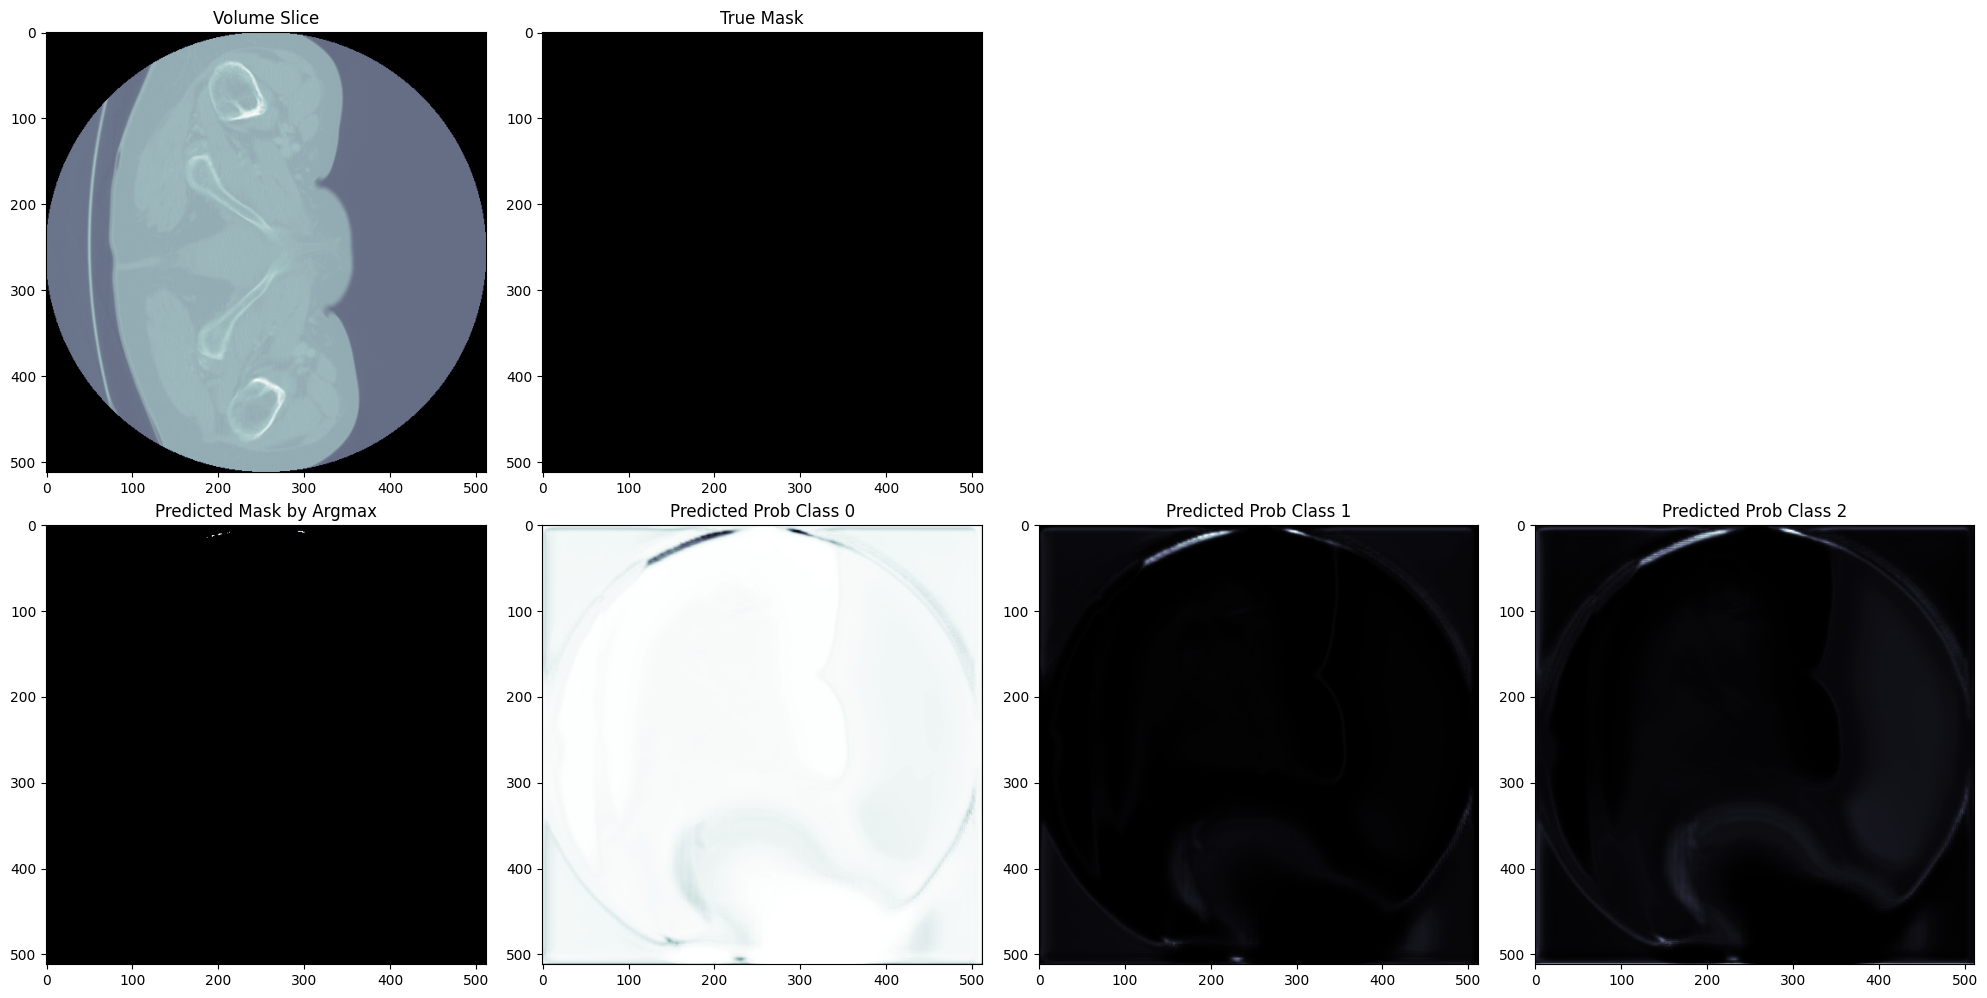

Processing slices:   0%|          | 0/123 [00:00<?, ?it/s]

volume slice min&max: (tensor(-3024.), tensor(1388.))
volume slice min&max: (tensor(-3024.), tensor(1345.))
volume slice min&max: (tensor(-3024.), tensor(1395.))
volume slice min&max: (tensor(-3024.), tensor(1332.))
volume slice min&max: (tensor(-3024.), tensor(1367.))
volume slice min&max: (tensor(-3024.), tensor(1393.))
volume slice min&max: (tensor(-3024.), tensor(1377.))


KeyboardInterrupt: 

In [14]:
from IPython.display import display
from tqdm.notebook import tqdm
import gc
import torch
from torch.autograd import Variable

# 假设已定义 num_epochs, data_loader, device, model, criterion, optimizer
for epoch in range(num_epochs):
    total_loss = 0.0
    with tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=True) as outer_tqdm:
        for batch_idx, (volume_slices, mask_slices) in outer_tqdm:
            D = volume_slices.shape[-1]

            with tqdm(range(D), desc='Processing slices', leave=False) as inner_tqdm:
                for d in inner_tqdm:
                    volume_slice = volume_slices[:, :, :, d].unsqueeze(1).to(device)
                    print(f'volume slice min&max: {volume_slice.min(), volume_slice.max()}')

                    # print(f'volume_slice shape: {volume_slice.shape}') # volume_slice shape: torch.Size([1, 1, 512, 512])
                    mask_slice = mask_slices[:, :, :, d].to(device)  # mask_slice shape: torch.Size([1, 512, 512])
                    # print(f'mask_slice shape: {mask_slice.shape}')
                    # print(f'mask_slice unique value: {torch.unique(mask_slices)}')
                    # print(f'mask_slice unique value: {torch.unique(mask_slice.long())}')
                    optimizer.zero_grad()
                    outputs = model(volume_slice) # torch.Size([1, 3, 512, 512])
                    # print(f'outputs min&max: {outputs.min(), outputs.max()}')
                    # print(f'outputs shape: {outputs.shape}')

                    # 假设损失函数（如 CrossEntropyLoss）能直接处理类别索引形式的掩码
                    loss = criterion(outputs, mask_slice.long())
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    inner_tqdm.set_postfix(loss=loss.item())


            random_d = random.randint(0, D-1)

            predict_and_visualize(model, volume_slices[:, :, :, random_d].unsqueeze(1).to(device), mask_slices[:, :, :, random_d].to(device))

            avg_loss = total_loss / ((batch_idx + 1) * D)
            outer_tqdm.set_postfix(avg_loss=avg_loss)

print('Finished Training')


In [ ]:
from IPython.display import display
from tqdm.notebook import tqdm
import gc

for epoch in range(num_epochs):
    total_loss = 0.0
    with tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=True) as outer_tqdm:
        for batch_idx, (volume_slices, mask_slices) in outer_tqdm: # torch.Size([1, 1, 512, 512, D]) torch.Size([1, 3, 512, 512, D])
            D = volume_slices.shape[-1]
            # print mask_slices unique value
            # print(f'mask_slices unique value: {torch.unique(mask_slices)}')

            with tqdm(range(D), desc='Processing slices', leave=False) as inner_tqdm:
                for d in inner_tqdm:
                    volume_slice = volume_slices[:, :, :, d].unsqueeze(1).to(device)
                    mask_slice = mask_slices[:, :, :, :, d].to(device)

                    # print(volume_slice.shape, mask_slice.shape)
                    # break

                    optimizer.zero_grad()
                    outputs = model(volume_slice) # torch.Size([1, 3, 512, 512])
                    # print(f'outputs shape: {outputs.shape}')
                    # mask_slice_argmax = torch.argmax(mask_slice, 1) # torch.Size([1, 512, 512])
                    # print(f'mask_slice_argmax shape: {mask_slice_argmax.shape}')
                    # print mask_slice_argmax unique value
                    # print(f'mask_slice_argmax unique value: {torch.unique(mask_slice_argmax)}')

                    loss = criterion(outputs, mask_slice)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    inner_tqdm.set_postfix(loss=loss.item())
                    # accuracy = compute_accuracy(outputs, mask_slice_argmax)

                    # del volume_slice, mask_slice
                    # gc.collect()

            # Predict and visualize after processing all slices of the current batch
            # Here we randomly select one slice to predict and visualize
            random_d = random.randint(0, D-1)
            predict_and_visualize(model, volume_slices[:, :, :, random_d].unsqueeze(1).to(device), mask_slices[:, :, :, :, random_d].to(device))
                          # torch.Size([1, 1, 512, 512]) torch.Size([1, 3, 512, 512])

            avg_loss = total_loss / ((batch_idx + 1) * D)
            outer_tqdm.set_postfix(avg_loss=avg_loss)

    # plot_metrics({'Training Loss': [total_loss / ((batch_idx + 1) * D)]}, title=f'Epoch {epoch+1}/{num_epochs} - Training Loss')

Epoch 1/5:   0%|          | 0/51 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/75 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 4

# **Rest**

In [ ]:
# from tqdm import tqdm

# # 模拟训练过程
# for volume_slices, mask_slices in tqdm(data_loader, desc='Training'):
#     D = volume_slices.shape[-1]  # 获取切片数量
#     total_loss = 0.0  # 初始化累计损失

#     for d in tqdm(range(D)):
#         volume_slice = volume_slices[:, :, :, d].unsqueeze(1).to(device)
#         mask_slice = mask_slices[:, :, :, :, d].to(device)
#         # print(volume_slice.shape, mask_slice.shape)

#         optimizer.zero_grad()

#         outputs = model(volume_slice)

#         # 将掩膜转换为类别索引形式 (B, H, W)
#         mask_slice = torch.argmax(mask_slice, 1)  # 在类别维度上使用argmax

#         loss = criterion(outputs, mask_slice.long())
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         # tqdm.write(f'Loss: {loss.item():.4f}')

#     # 计算并显示当前批次的平均损失
#     avg_loss = total_loss / D
#     tqdm.write(f'Average loss: {avg_loss:.4f}')


Training:   0%|          | 0/51 [00:19<?, ?it/s]


KeyboardInterrupt: 

# **We've got data, so next step is to preprocess🍖**
1. Get the fucking slices
2. Convert them tensors
2. Maybe some resize?
3. Windowed to the volume slices

In [ ]:
volume_list, segmentation_list

In [ ]:
test_volume = read_nii(volume_list[0])
test_volume.shape

(512, 512, 75)

# **Get into the dataloader part (everytime really stressing me out🤬)**

In [ ]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
from random import randint
import torch.nn.functional as F


dicom_windows = types.SimpleNamespace( # some tuples to store
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(400,100),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)


def read_nii(filepath, interval=3):
    '''
    Reads .nii file and returns selected slices as a NumPy array.
    '''
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    selected_slices = array[:,:,::interval]  # Assuming the slicing dimension is the last one
    selected_slices = np.rot90(np.array(selected_slices))
    return selected_slices.copy()

class NiiDataset(Dataset):
    def __init__(self, volume_list, segmentation_list, transform=None):
        self.volume_list = volume_list
        self.segmentation_list = segmentation_list
        self.transform = transform

    def __len__(self):
        return len(self.volume_list)

    def __getitem__(self, idx):
        volume_path = self.volume_list[idx]
        segmentation_path = self.segmentation_list[idx]

        volume_slices = read_nii(volume_path)
        segmentation_slices = read_nii(segmentation_path)

        # Convert slices to tensors
        volume_slices = tensor(volume_slices.astype(np.float32)).windowed(*dicom_windows.liver)
        segmentation_slices = tensor(segmentation_slices.astype(np.int64))

        # Handle segmentation (optional, depending on your model's needs)
        # One-hot encoding
        segmentation_slices = F.one_hot(segmentation_slices, num_classes=3)  # 3 classes in your case
        segmentation_slices = segmentation_slices.permute(3, 0, 1, 2).contiguous()
        # Resulting shape: [slices, channels, height, width]

        # Align slices (if necessary, this step can include preprocessing such as normalization)

        if self.transform:
            volume_slices = self.transform(volume_slices)
            segmentation_slices = self.transform(segmentation_slices)



        return volume_slices, segmentation_slices


In [ ]:
dataset = NiiDataset(volume_list, segmentation_list)
testData = DataLoader(dataset, batch_size=1, shuffle=False)
for volume, segmentation in dataset:
    volume_shape = volume.shape
    segmentation_shape = segmentation.shape

    index = segmentation.shape[-1] // 2  # Get the middle slice index
    volume_slice = volume[:, :, index].numpy()  # Convert to NumPy array and select first slice
    volume_slice_shape = volume_slice.shape
    segmentation_slice = segmentation[:, :, :, index].numpy()  # Convert to NumPy array and select first slice
    segmentation_slice_shape = segmentation_slice.shape





    print(f"Volume Shape:        {volume_shape}")
    print(f"Volume Slice Shape:     {volume_slice_shape}")
    print(f"Segmentation Shape:  {segmentation_shape}")
    print(f"Segmentation Slice Shape: {segmentation_slice.shape}")
    print(f"Volume Data Type:    {volume.dtype}")
    print(f"Segmentation Type:   {segmentation.dtype}")
    print(f"Volume Type:         {volume.type()}")
    print(f"Segmentation Type:   {segmentation.type()}")
    print(f"Volume Min/Max:      {volume.min()}/{volume.max()}")
    print(f"Segmentation Min/Max: {segmentation.min()}/{segmentation.max()}")
    print(f"Segmentation Unique: {segmentation.unique()}")

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(volume_slice)
    ax[0].set_title('Volume Slice')
    ax[0].axis('off')  # Turn off axis

    ax[1].imshow(segmentation_slice[0])
    ax[1].set_title('Background')
    ax[1].axis('off')  # Turn off axis

    ax[2].imshow(segmentation_slice[1])
    ax[2].set_title('Liver')
    ax[2].axis('off')  # Turn off axis

    ax[3].imshow(segmentation_slice[2])
    ax[3].set_title('Tumor')
    ax[3].axis('off')  # Turn off axis

    plt.show()


# **MODEL setup🥲**

# **Finally the training loop🥱**

In [ ]:
# !pip install segmentation_models_pytorch
# import segmentation_models_pytorch as smp